###Import Libraries

In [1]:
import matplotlib.pylab as plt
from time import time
import numpy as np
import pandas as pd
import os
from collections import Counter,defaultdict
%matplotlib inline

In [2]:
from time import time
import pickle
import sys
import json

###Get Image File Names

In [3]:
def get_image_file_name_path(path):
    filelist = []
    for i, filename in enumerate(os.listdir(path)):
        # exclude the error log file
        if "ds_store" not in filename.lower():
            filelist.append(filename)
    return filelist

In [4]:
image_file_name_path = "/Users/Alexander/NASA/NASA_Sample_Data/Images/"
filelist = get_image_file_name_path(image_file_name_path)

In [5]:
print "Total number of files = {}.".format(len(filelist))

Total number of files = 413.


###Get Mapped Image Data

In [6]:
# get image file names
def get_image_trans_filenames(path):
    return [image for image in os.listdir(path)]

In [7]:
trans_image_path = "/Users/Alexander/NASA/trans_image_data_test/"
trans_filenames_test = get_image_trans_filenames(trans_image_path)

In [11]:
print "{} even spaced sample images".format(len(trans_filenames_test )- 1)
trans_filenames_test

8 even spaced sample images


['.DS_Store',
 'fd_M_96m_01d_3925_0001.pk',
 'fd_M_96m_01d_3929_0013.pk',
 'fd_M_96m_01d_3933_0011.pk',
 'fd_M_96m_01d_3937_0002.pk',
 'fd_M_96m_01d_3940_0007.pk',
 'fd_M_96m_01d_3944_0007.pk',
 'fd_M_96m_01d_3947_0012.pk',
 'fd_M_96m_01d_3951_0002.pk']

In [12]:
# get transformed image data -- Equal Area Cylindrical Maps\
def get_trans_image(path,image_data):
    trans_images = []
    for i, image in enumerate(image_data):
        if "ds_store" not in image.lower():
            trans_images.append(pickle.load(open(path + image,'r')).values)
    return trans_images

In [13]:
trans_image_path = "/Users/Alexander/NASA/trans_image_data_test/"
trans_images = get_trans_image(trans_image_path, trans_filenames_test)

In [14]:
print "{} mapped image files".format(len(trans_images))
print type(trans_images[0])
print trans_images[0].shape
print trans_images[0]

8 mapped image files
<type 'numpy.ndarray'>
(1024, 1024)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


###Get Extracted Features from File

In [17]:
def get_features(path):
    file_names = []
    feat_extract_list = []
    for result in os.listdir(path):
        if "ds_store" not in result.lower():
            file_names.append(result)
            print result
            feat_extract_list.append( pd.read_pickle(path + result).values)
    return feat_extract_list

In [18]:
path_results = "/Users/Alexander/NASA/feature_extraction_results_test/"
feats = get_features(path_results)

fd_M_96m_01d_3925_0001.pk
fd_M_96m_01d_3929_0013.pk
fd_M_96m_01d_3933_0011.pk
fd_M_96m_01d_3937_0002.pk
fd_M_96m_01d_3940_0007.pk
fd_M_96m_01d_3944_0007.pk
fd_M_96m_01d_3947_0012.pk
fd_M_96m_01d_3951_0002.pk


###Convert Centroid Positions into Longitude & Latitude 

In [19]:
# Notes from talk with David - Jan 22, 2016
# Saving results to text file
# Image Name should HMIYYYY.txt (i.e. discripter date . txt )
# header: |YYYY MM DD| |hh:mm:ss| |Active Region #| |Flux| |Longitude| |Latitude|
#                                  xxxxxx[letter]     +/-     xxx.xx     xxx.xx
# unidentifed active regions, label them starting at 100,000 
# will have to `bmap pixels to longitude and latitude 
# can provide lead digit to indicate that we have observed an active region that NOAA has not
# we want the carinton longitude 

In [20]:
def truncate(num):
    before_dec, after_dec = str(num).split('.')
    return float('.'.join((before_dec, after_dec[0:2])))

In [21]:
def map_centroids_long_lat(features):
    '''INPUT: feat_dict for single image
    '''
    feat_dict = features[1][0]    
    feat_dict_copy = feat_dict.copy()
    # get active region centroids in order to convert to long and lat
    active_regions = dict()
    for feature, value in feat_dict.iteritems():
        if isinstance(feature, int) == True or feature == 'car_long'or feature == 'image_type':
            # collect features for each active region as key:value pairs
            active_regions[feature] = value
            
    # all active regions, from the same image, share the same carinton longitude 
    carrinton_long = active_regions['car_long'] 
    image_type = active_regions['image_type']
    
    return map_coordinats(active_regions, feat_dict_copy, carrinton_long, image_type )

In [22]:
def get_long_lat(Xcen, Ycen, clon1, image_type):
    from math import asin, pi
    convert_degrees_MDI = 180.0/1024
    convert_degrees_HMI = 180.0/4096
    
    if image_type == "MDI":
        Longitude = clon1 + ((Xcen - 511.5) * convert_degrees_MDI)
        Latitude = asin((Ycen - 511.5)/512)
    else:
        Longitude = clon1 + ((Xcen - 2047.5) * convert_degrees_HMI)
        Latitude = asin((Ycen - 2047.5)/2048)
        
    # truncate bleeding edges
    Longitude = (Longitude + 360) % 360
    # conversion from radius to degrees
    Latitude = Latitude * 180/pi
    
    return Longitude, Latitude

In [23]:
# longitude error may be here 
def map_coordinats(active_regions, feat_dict_copy, carrinton_long, image_type):
    for key, value in active_regions.iteritems():
        if key == 0:
            continue
        if isinstance(key, int) == True:
            pos_long, pos_lat = get_long_lat(value['x_pos_ave'], 
                                             value['y_pos_ave'],
                                             carrinton_long,
                                             image_type)
            neg_long, neg_lat = get_long_lat(value['x_neg_ave'], 
                                             value['y_neg_ave'],
                                             carrinton_long,
                                             image_type)

            feat_dict_copy[key]['long_pos'] = truncate(pos_long)
            feat_dict_copy[key]['lat_pos'] = truncate(pos_lat)
            feat_dict_copy[key]['long_neg'] = truncate(neg_long)
            feat_dict_copy[key]['lat_neg'] = truncate(neg_lat)
    return feat_dict_copy

In [24]:
# get longitude and latitude values for each active region in each image
new_feat_objects = [map_centroids_long_lat(feat) for feat in feats]

In [25]:
for feat in feats:
    print feat[1][0]
    break

{1: {'y_pos_ave': 387.76, 'x_pos_ave': 413.9, 'long_neg': 280.94, 'lat_pos': -13.98, 'pos_net_flux': 297568.0, 'neg_net_flux': -197.46, 'long_pos': 279.29, 'y_neg_ave': 388.73, 'x_neg_ave': 423.26, 'lat_neg': -13.87}, 2: {'y_pos_ave': 433.94, 'x_pos_ave': 90.77, 'long_neg': 222.54, 'lat_pos': -8.71, 'pos_net_flux': 2537983.48, 'neg_net_flux': -58842.4, 'long_pos': 222.49, 'y_neg_ave': 435.15, 'x_neg_ave': 91.02, 'lat_neg': -8.57}, 3: {'y_pos_ave': 446.82, 'x_pos_ave': 179.47, 'long_neg': 239.0, 'lat_pos': -7.25, 'pos_net_flux': 121496.19, 'neg_net_flux': -122593.32, 'long_pos': 238.08, 'y_neg_ave': 445.75, 'x_neg_ave': 184.67, 'lat_neg': -7.37}, 4: {'y_pos_ave': 473.86, 'x_pos_ave': 717.5, 'long_neg': 334.0, 'lat_pos': -4.21, 'pos_net_flux': 13283.0, 'neg_net_flux': -66751.8, 'long_pos': 332.66, 'y_neg_ave': 466.65, 'x_neg_ave': 725.1, 'lat_neg': -5.02}, 5: {'y_pos_ave': 547.46, 'x_pos_ave': 896.82, 'long_neg': 6.61, 'lat_pos': 4.02, 'pos_net_flux': 1603050.0, 'neg_net_flux': -17506.04

In [26]:
# code has been put into place so that net_flux values are truncated 
new_feat_objects[0]

{1: {'lat_neg': -13.87,
  'lat_pos': -13.98,
  'long_neg': 280.94,
  'long_pos': 279.29,
  'neg_net_flux': -197.46,
  'pos_net_flux': 297568.0,
  'x_neg_ave': 423.26,
  'x_pos_ave': 413.9,
  'y_neg_ave': 388.73,
  'y_pos_ave': 387.76},
 2: {'lat_neg': -8.57,
  'lat_pos': -8.71,
  'long_neg': 222.54,
  'long_pos': 222.49,
  'neg_net_flux': -58842.4,
  'pos_net_flux': 2537983.48,
  'x_neg_ave': 91.02,
  'x_pos_ave': 90.77,
  'y_neg_ave': 435.15,
  'y_pos_ave': 433.94},
 3: {'lat_neg': -7.37,
  'lat_pos': -7.25,
  'long_neg': 239.0,
  'long_pos': 238.08,
  'neg_net_flux': -122593.32,
  'pos_net_flux': 121496.19,
  'x_neg_ave': 184.67,
  'x_pos_ave': 179.47,
  'y_neg_ave': 445.75,
  'y_pos_ave': 446.82},
 4: {'lat_neg': -5.02,
  'lat_pos': -4.21,
  'long_neg': 334.0,
  'long_pos': 332.66,
  'neg_net_flux': -66751.8,
  'pos_net_flux': 13283.0,
  'x_neg_ave': 725.1,
  'x_pos_ave': 717.5,
  'y_neg_ave': 466.65,
  'y_pos_ave': 473.86},
 5: {'lat_neg': 3.27,
  'lat_pos': 4.02,
  'long_neg': 6.6

### Load NOAA Sunspot Files
    Need to Normalize Date Syntax

In [27]:
# tokenize features for all years
def tokenize_NOAA_files(noaa_path, files):
    '''INPUT: path to NOAA directory, text files 
       OUTPUT: tokenized text files
    '''
    import regex as re
    tokenized_files = []
    regexp = "[0-9a-zA-Z]+"
    for year in files:
        year = pd.read_table(noaa_path + year, sep='\t').values
        tokenized_files.append([re.findall(regexp,row[0]) for row in year])
    return tokenized_files

In [28]:
def check_date_syntax(row):
    '''INPUT: list with tokenized string
       OUTPUT: list with correctly tokenized string
    '''
    if len(row[1]) == 1 and len(row[2]) == 1:
        mod = [row[0] + "0"+ row[1] + "0"+ row[2]]
        return mod + row[3:]
    elif len(row[1]) == 3:
        mod  = [row[0] + "0"+row[1]]
        return mod + row[2:]
    else:
        return row

In [29]:
def correct_date_syntax(years):
    '''INPUT: nested list, each list corresponds to one year
       OUTPUT: dictionary, 
               keys: years YYYY
               values: nested list, each list corresponds to one year
               list of date string lengths for debugging 
    '''
    correct_years = dict()
    santiy_check = []
    for year in years:
        correct_year = []
        for row in year:
            correct_row = check_date_syntax(row)
            correct_year.append(correct_row)
            santiy_check.append(len(correct_row[0]))
        correct_years[row[0][0:4]] = correct_year
    return correct_years, np.unique(santiy_check)

In [30]:
def get_noaa_sunspot_files(path):
    # load file names
    sunspot_files = [file_ for file_ in os.listdir(noaa_path)]
    # each row is a string, tokenize it
    tokenized_results = tokenize_NOAA_files(noaa_path, sunspot_files)
    # normalize date syntax
    results, _ = correct_date_syntax(tokenized_results)
    return results

In [31]:
# noaa_year = '2003'
# noaa_path = "/Users/Alexander/NASA/MDI_data/rgn{}.txt".format(noaa_year)
noaa_path = "/Users/Alexander/NASA/MDI_data/"
# noaa_data is a dictionary
noaa_data = get_noaa_sunspot_files(noaa_path)

In [32]:
# Batch load NOAA files, size is not a problem
print "Byte size of NOAA files for 12 years {} bytes".format(sys.getsizeof(noaa_data))

Byte size of NOAA files for 12 years 1048 bytes


In [33]:
noaa_data.keys()

['1997',
 '1996',
 '1999',
 '1998',
 '2002',
 '2003',
 '2000',
 '2001',
 '2006',
 '2007',
 '2004',
 '2005',
 '2015',
 '2014',
 '2008',
 '2009',
 '2011',
 '2010',
 '2013',
 '2012']

###Get Active Region Numbers

In [34]:
k = 7
print new_feat_objects[k]['image_date']
print new_feat_objects[k]['image_time']
print new_feat_objects[k]['image_date'][0:4]
current_year = new_feat_objects[k]['image_date'][0:4]

2003 10 27
03:11:03
2003


In [35]:
"".join(new_feat_objects[k]['image_date'].split())

'20031027'

In [60]:
mydata_x = []
mydata_y = []
ar_cents = []
print "POLARITY   LAT    LONG"
for ar_num, ar_vals in new_feat_objects[k].iteritems():
    if isinstance(ar_num, int) and ar_num > 0:
        mydata_x.append(ar_vals['long_pos'])
        mydata_y.append(ar_vals['lat_pos'])
        mydata_x.append(ar_vals['long_neg'])
        mydata_y.append(ar_vals['lat_neg'])
        # get overall active region centroid for the labeling process
        x_cent = (ar_vals['long_pos'] + ar_vals['long_neg'])/2.
        y_cent = (ar_vals['lat_pos'] + ar_vals['lat_neg'])/2.
        ar_cents.append([x_cent,y_cent])
        
        
        print "positive ", ar_vals['lat_pos'], " ", ar_vals['long_pos']
        print "negative ", ar_vals['lat_neg'], " ", ar_vals['long_neg']
        print ''

POLARITY   LAT    LONG
positive  -16.9   284.03
negative  -16.76   286.36

positive  4.72   356.48
negative  3.55   355.4

positive  11.13   257.8
negative  11.35   253.85

positive  -12.65   297.04
negative  -12.47   297.15

positive  8.5   294.8
negative  6.96   292.83



### date syntax used to scan df

In [37]:
np.arange(1, 400, 50)

array([  1,  51, 101, 151, 201, 251, 301, 351])

In [38]:
# date syntax used to scan df
print "".join(new_feat_objects[k]['image_date'].split())
scan_year = "".join(new_feat_objects[k]['image_date'].split())

20031027


In [39]:
# |date|  |ar_num| |lat/long| |clon| |area(Msolar-hemishpere)|
df = pd.DataFrame(noaa_data[current_year])
df.columns = ["date", 'activeRegionNum', "latLong", "clon", "area", 5,6,7,8]
df = df[["date", 'activeRegionNum', "latLong", "clon", "area"]]

###get active region numbers from NOAA data set

In [40]:
df[scan_year == df.date]

,date,activeRegionNum,latLong,clon,area
1814,20031027,10484,N03W54,355,1440
1815,20031027,10486,S16E18,283,2180
1816,20031027,10487,N14E46,255,0240
1817,20031027,10488,N09E09,292,0270
1818,20031027,10489,S11E05,296,0030
1819,20031027,10490,S10E25,276,0050
1820,20031027,10491,S06E09,292,0050
1821,20031027,10492,S22W20,321,0010


In [41]:
df[scan_year == df.date].latLong.values

array(['N03W54', 'S16E18', 'N14E46', 'N09E09', 'S11E05', 'S10E25',
       'S06E09', 'S22W20'], dtype=object)

In [73]:
def get_centroids(df, scan_year):
    '''
    gets x and y components of centroids from NOAA data
    INPUT: dataframe containing all NOAA documented active regions (and revelent features) 
    OUTPUT: active region centroids x and y components seperately and jointly 
    '''
    nova_x = []
    nova_y = []
    nova_cents = []
    for lat, clon in zip(df[scan_year == df.date].latLong.values,df[scan_year == df.date].clon.values ):
        nova_y.append(int(lat[1:3]))
        nova_x.append( int(clon))
        nova_cents.append([int(clon),int(lat[1:3])])
        
    return nova_x, nova_y, nova_cents

In [74]:
# these are my centroid 
nova_x , nova_y, nova_cents  = get_centroids(df, scan_year)

In [75]:
# NOAA active region coordinates
print len(nova_x)
print len(nova_y )
print nova_cents

8
8
[[355, 3], [283, 16], [255, 14], [292, 9], [296, 11], [276, 10], [292, 6], [321, 22]]


In [45]:
# these are my sunspot coordiantes 
print mydata_x
print mydata_y

[284.03, 286.36, 356.48, 355.4, 257.8, 253.85, 297.04, 297.15, 294.8, 292.83]
[-16.9, -16.76, 4.72, 3.55, 11.13, 11.35, -12.65, -12.47, 8.5, 6.96]


In [61]:
# get active region centroids from my_data
ar_cents

[[285.195, -16.83],
 [355.94, 4.135],
 [255.825, 11.24],
 [297.095, -12.56],
 [293.815, 7.73]]

###Sanity Check
    Check if centroids are located where you'd expected them to be

In [46]:
new_feat_objects[k]

{1: {'lat_neg': -16.76,
  'lat_pos': -16.9,
  'long_neg': 286.36,
  'long_pos': 284.03,
  'neg_net_flux': -1620121.48,
  'pos_net_flux': 15763687.2,
  'x_neg_ave': 360.86,
  'x_pos_ave': 347.64,
  'y_neg_ave': 363.85,
  'y_pos_ave': 362.64},
 2: {'lat_neg': 3.55,
  'lat_pos': 4.72,
  'long_neg': 355.4,
  'long_pos': 356.48,
  'neg_net_flux': -1345583.98,
  'pos_net_flux': 5478616.11,
  'x_neg_ave': 753.63,
  'x_pos_ave': 759.77,
  'y_neg_ave': 543.29,
  'y_pos_ave': 553.71},
 3: {'lat_neg': 11.35,
  'lat_pos': 11.13,
  'long_neg': 253.85,
  'long_pos': 257.8,
  'neg_net_flux': -265026.32,
  'pos_net_flux': 2782446.08,
  'x_neg_ave': 175.92,
  'x_pos_ave': 198.42,
  'y_neg_ave': 612.27,
  'y_pos_ave': 610.39},
 4: {'lat_neg': -12.47,
  'lat_pos': -12.65,
  'long_neg': 297.15,
  'long_pos': 297.04,
  'neg_net_flux': -58.55,
  'pos_net_flux': 1291517.0,
  'x_neg_ave': 422.27,
  'x_pos_ave': 421.6,
  'y_neg_ave': 400.94,
  'y_pos_ave': 399.33},
 5: {'lat_neg': 6.96,
  'lat_pos': 8.5,
  'lo

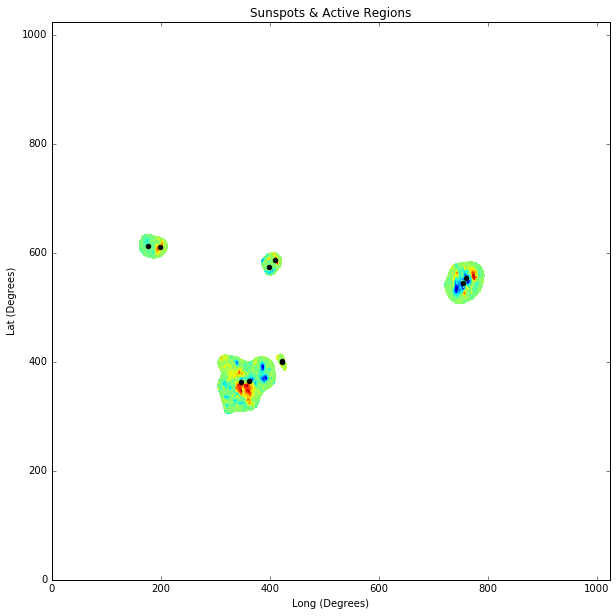

In [47]:
plt.figure(figsize = (10,10));
test_plot_diff  = np.ma.masked_where(trans_images[k] == 0.0, trans_images[k] )
#for key, value in results.iteritems():
    #print key, value[0]
    #print key, value[0][0], value[0][1], value[0][2], value[0][3]
for index in new_feat_objects[k].keys()[0:-4]:
    plt.scatter(new_feat_objects[k][index]["x_pos_ave"],new_feat_objects[k][index]["y_pos_ave"], c='k', marker ='o');
    plt.scatter(new_feat_objects[k][index]["x_neg_ave"],new_feat_objects[k][index]["y_neg_ave"], c='k', marker ='o');
    #plt.scatter(value[0][3],  value[0][7], c='k')
    
plt.imshow(test_plot_diff, interpolation='none', origin='lower');
plt.title("Sunspots & Active Regions");
plt.xlabel("Long (Degrees)");
plt.ylabel("Lat (Degrees)");
plt.show();
# plt.xlim([400,440])
# plt.ylim([380,420])

##False Positves are getting through !
    
    Clustering Challenges 
    In test image k = 7, there is a small patch of flux that is classified as an active region. 
    However upon human inspection, I can see that that patch is really part of a larger, nearby 
    active region. 
    
    Need to design clustering algorithm that detects this close promxity between clusters, 
    if two clusters are sufficiently close to each other, then they should be treated as one
    region and clustering analysis should be ran to determine if it makes sense to think of them 
    as a single cluster or as two. 
    

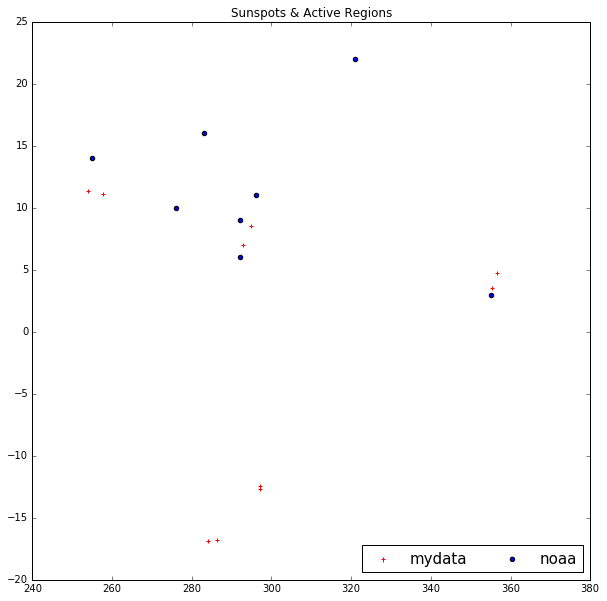

In [48]:
plt.figure(figsize=(10,10))
noaa = plt.scatter(nova_x, nova_y, c='b', marker='o');
me = plt.scatter(mydata_x, mydata_y , c='r',marker='+');
plt.title("Sunspots & Active Regions");
plt.legend((me, noaa),
           ('mydata', 'noaa'),
           scatterpoints=1,
           loc='lower right',
           ncol=2,
           fontsize=15);

##Notes
    The above plot shows that the coordinates of my data and the coordinates of the NOAA 
    are significantly different. 
    
    Apply KNN to assign active region number from NOAA to my data. 
    Pick nearest NOAA point for labeling. 
    If nearest point is further than a 5 degree radius from my data point, 
    Then assign a new active region label. 

###Next
    Apply a distance algorithm (KNN?) to assign the active region labels. 
    Then wrap up the above code in functions

In [479]:
print ar_cents
print nova_cents

[[285.195, -16.83], [355.94, 4.135], [255.825, 11.24], [297.095, -12.56], [293.815, 7.73]]
[[355, 3], [283, 16], [255, 14], [292, 9], [296, 11], [276, 10], [292, 6], [321, 22]]


In [104]:
from scipy.spatial.distance import  euclidean

In [232]:
# calculate the distance between every possible pair of points: mydata points and nova data points 
# if distance is less than 5 degrees, 
# append distance and ar_cent to dict
# choose shorest distance for each pair
# then assign corresponding active region label
# else assign new active region label
def get_neighbor_distances(ar_cents,nova_cents):
    '''
    calculate the distance between every possible pair of points: mydata points and nova data points 
    '''
    ar_dist = defaultdict(list)
    for i, ar_cent in enumerate(ar_cents):
        novaDict = dict()
        for j, nova_cent in enumerate(nova_cents):
            dist = euclidean(ar_cent, nova_cent)
            # if distance is less than 5 degrees, 
            # append distance and ar_cent to dict
            if dist <= 5:
                ar_dist[i].append(dict({j:dist}))
    return ar_dist

In [244]:
def get_shortest_distance_pair(ar_dist):
    for mydata_index, novaDist in ar_dist.iteritems():
        # check if active region has more than one NOAA match
        if len(novaDist) > 1:
            dist_i = None
            noaa_i = None

            ar_match_i = 0 
            for dist_dict in novaDist:
                for noaaInd, dist in dist_dict.iteritems():
                    if ar_match_i == 0:
                        noaa_i = noaaInd
                        dist_i = dist
                    else:
                        if dist < dist_i:
                            dist_i = dist
                            noaa_i = noaaInd
                    ar_match_i += 1
            ar_dist[mydata_index] = [{noaa_i: dist_i}]
    return ar_dist

##ToDO - For a Single Image
    1. Give an active region label to each mydata point
        If mydata point is within a 5 degree radius to a noaa data point
            Then assgin the corresponding active region label
            Else generate a new active region label 
        
        If the same noaa data point is assign to more than 1 mydata point
            Then check which mydata point is cloesest to the noaa data point
                Assign cloesest data point corresponding active region number
                Generate a new active region label for other mydata point

In [486]:
ar_dist = get_neighbor_distances(ar_cents, nova_cents)

In [487]:
for key, value in ar_dist.iteritems():
    print key, value

1 [{0: 1.47371130144272}]
2 [{2: 2.880663985958789}]
4 [{3: 2.215203150954781}, {4: 3.9328265916513545}, {6: 2.507414006501518}]


In [488]:
ar_dict = get_shortest_distance_pair(ar_dist)

In [489]:
for key, value in ar_dict.iteritems():
    print key, value

1 [{0: 1.47371130144272}]
2 [{2: 2.880663985958789}]
4 [{3: 2.215203150954781}]


###Check for assignment of a single NOAA data point to multiple mydata points

In [474]:
def check_repeating_noaa_assignments(mydata):
    # check for repeating noaa assignments for a single image
    noaa_ar = []
    for mydata_ind, noaaInd_minDist in mydata.iteritems():
        noaa_ar.append(noaaInd_minDist[0].keys()[0])
    
    return noaa_ar

In [475]:
def get_repeating_noaa_points(noaa_ar):
    '''
    collect repeating noaa points in dictionary
    
    INPUT: list of noaa active region number appearances 
    OUTPTU: diction of noaa active region number and
            count of appearances key:value pairs 
    '''
    ar_count  = defaultdict(list)
    add_one = 1
    # append one everytime a noaa active region number appears
    for ar_num in noaa_ar:
        ar_count[ar_num].append(add_one)
    # sum the number of times a noaa active region number appears 
    for key in ar_count.keys():
        ar_count[key] = np.sum(ar_count[key])
        
    # only collect the repeating noaa active region numbers 
    repeating_noaa_ar = []
    for noaa_ar_num, count in ar_count.iteritems():
        if count > 1:
            repeating_noaa_ar.append(noaa_ar_num)
     
    return repeating_noaa_ar

In [476]:
def get_mydata_index_for_poping(repeating_noaa, mydata):
    '''
       There are multiple mydata points that have been assigned to 
       the same noaa active region number. Identify the matched pair 
       that has the greatest distance between, return the correstponding 
       mydata index. 
    '''
    mydata_drop_list = []
    loop_counter = 0 
    dist_i = None
    mydata_i = None
    
    for mydata_ind, noaaInd_minDist in mydata.iteritems():
        # check if noaa active region number  
        # is in list of repeating noaa numbers 
        noaa_ar_num = noaaInd_minDist[0].keys()[0]
        
        if noaa_ar_num == repeating_noaa:
            if loop_counter == 0:
                dist_i = noaaInd_minDist[0].values()
                mydata_i = mydata_ind
            else:
                if dist_i < noaaInd_minDist[0].values():
                    dist_i = noaaInd_minDist[0].values()
                    mydata_i = mydata_ind  
            loop_counter += 1
    return mydata_i

In [510]:
# Expect --> 1: [{0: 1.47371130144272} to be paired with noaa_index
# Expect --> 4: {0: 2.215203150954781} to be droped 

# { mydata index : [{ noaa_index : min_dist }] }
dummy_mydata = {1: [{0: 1.47371130144272}], 2: [{0: 2.880663985958789}], 4: [{0: 2.215203150954781}]}
print "mydata and noaa pairings ARE NOT one-to-one\n"
for key, value in dummy_mydata.iteritems():
    print key, value

mydata and noaa pairings ARE NOT one-to-one

1 [{0: 1.47371130144272}]
2 [{0: 2.880663985958789}]
4 [{0: 2.215203150954781}]


## ToDo
    Case in which all mydata points are assiged to the same noaa active region number breaks
    Case in which n-1 mydata points are assiged to the same noaa active region number works
    

In [513]:
def check_repeating_noaa_assignments(data):
    '''
    Check if a multiple mydata points were assiged to the same noaa active region number
    
    '''

    noaa_ar = check_repeating_noaa_assignments(data)
    # if True, then there does not exist repeating noaa assignments 
    if len(noaa_ar) == len(np.unique(noaa_ar)):
        return data
    # there does exist repeating noaa assignments
    else:
        # identify and retrieve noaa active region numbers
        repeating_noaa_ar = get_repeating_noaa_points(noaa_ar)
        print repeating_noaa_ar
        # loop through the noaa numbers and 
        for repeating_noaa in repeating_noaa_ar:
            pop_index = get_mydata_index_for_poping(repeating_noaa, data)
            data.pop(pop_index)
        return data

In [514]:
print "mydata and noaa pairings ARE one-to-one"
for key, value in dummy_mydata.iteritems():
    print key, value

mydata and noaa pairings ARE one-to-one
1 [{0: 1.47371130144272}]
2 [{0: 2.880663985958789}]
4 [{0: 2.215203150954781}]


### Note on Indecies 
    while looping through the mydata and noaa pairings, I need to make sure that the loop index 
    and the mydata index are syncranized so that I can identify which mydata points where not
    assignemnt a noaa active region number. 
    
    These mydata points will have a new active region label
    generated for them. 
    
    Mydata points with noaa assignments will be assinged their corresponding noaa's
    active region number. 

### Move Extracted Features into Text 

In [34]:
# Notes from talk with David - Jan 22, 2016
# Saving results to text file
# Image Name should HMIYYYY.txt (i.e. discripter date . txt )
# header: |YYYY MM DD| |hh:mm:ss| |Active Region #| |Flux| |Longitude| |Latitude|
#                                  xxxxxx[letter]     +/-     xxx.xx     xxx.xx
# unidentifed active regions, label them starting at 100,000 
# will have to map pixels to longitude and latitude 
# can provide lead digit to indicate that we have observed an active region that NOAA has not
# we want the carinton longitude 
# 

In [ ]:
# one active region 
#
# header: |YYYY MM DD| |hh:mm:ss| |Active Region #| |Flux| |Longitude| |Latitude|
#                                  xxxxxx[letter]     +/-     xxx.xx     xxx.xx
#            n1             n2    get_active(n1,n2)  n4         n5        n6   
#            n7             n8    get_active(n7,n8)  n9         n10       n11

In [120]:
db_path = "/Users/Alexander/NASA/Database/"

In [196]:
def save_features_to_file(path, single_image):
    rows = []
    for feat_key, feat_val in single_image.iteritems():
        # filter out non-active regions and false positive active regions
        if isinstance(feat_key, int) and feat_key > 0:
            # get postive value features for active region
            row = [single_image['image_date'], 
                   single_image['image_time'], 
                   "10P", 
                   feat_val['pos_net_flux'], 
                   feat_val['long_pos'], 
                   feat_val['lat_pos']]
            rows.append('\t'.join(map(str,row)))
            # get negative value features for active region
            row = [single_image['image_date'],
                   single_image['image_time'], 
                   "10N", 
                   feat_val['neg_net_flux'], 
                   feat_val['long_neg'], 
                   feat_val['lat_neg']]
            rows.append('\t'.join(map(str,row)))

    # save active region features to text file
    pd.DataFrame(rows).to_csv(path + 'features.txt', 
                              index = False, 
                              header=False, 
                              mode='a')

In [197]:
for image in new_feat_objects:
    save_features_to_file(db_path, image)

In [ ]:
# for year in years
#     for image in year
#         

###Plot Sub-Set of Results

In [59]:
def plot_results(image_data, images_labels, index):
    plt.figure(figsize = (12,12));
    # file names of images (i.e. 'fd_M_96m_01d.3925.0000.fits')
    image_name = images_labels[index]
    for tup in centroid_dict[image_name]:
        plt.scatter(tup[0], tup[1], c='k')
        
    # mask backgroud with zeors
    image_plot  = np.ma.masked_where(image_data[index] == 0.0, image_data[index])
    plt.imshow(image_plot, interpolation='none', origin='lower');
    plt.title(image_name)
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")

####ToD0
    fix the sorting order that the files are saved in
    format storage of extracted features 
    need to validate this process for HMI data - processing time is much longer !!!

In [60]:
filenumbers[:10]

[0, 1, 10, 100, 101, 102, 103, 104, 105, 106]

In [61]:
plot_images =  [filelist[i] for i in filenumbers[:10]]

In [62]:
# late Oct 2003 ~ 30th
plot_images

['fd_M_96m_01d.3925.0000.fits',
 'fd_M_96m_01d.3925.0001.fits',
 'fd_M_96m_01d.3926.0007.fits',
 'fd_M_96m_01d.3933.0010.fits',
 'fd_M_96m_01d.3933.0011.fits',
 'fd_M_96m_01d.3933.0012.fits',
 'fd_M_96m_01d.3933.0013.fits',
 'fd_M_96m_01d.3933.0014.fits',
 'fd_M_96m_01d.3934.0000.fits',
 'fd_M_96m_01d.3934.0001.fits']

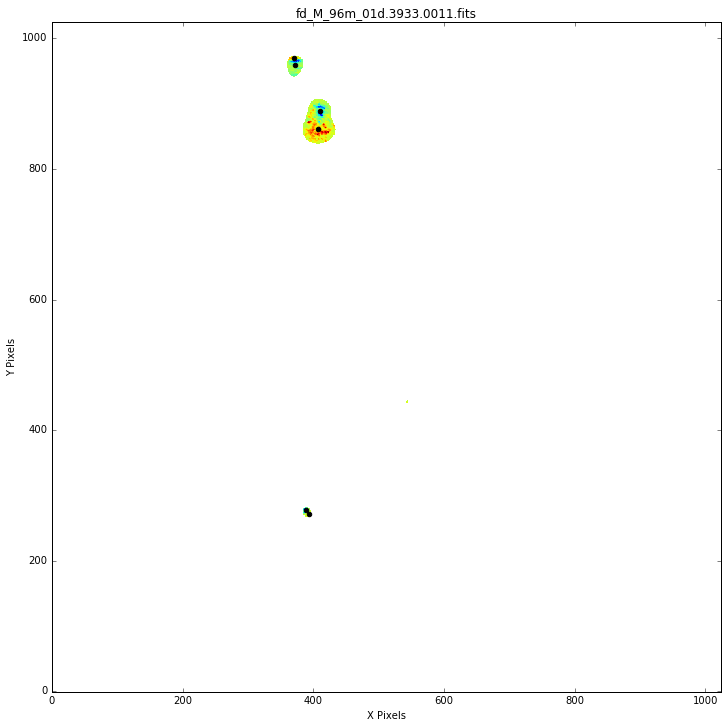

In [75]:
plot_results(trans_images, plot_images, 4)